# Table of Content

1. Data Analysis and Visualizaton  
    1.1 Linear Trend and Quadratic Trend      
    1.2 Moving Average(MA(p)) and Difference  
        Test: Ljung-Box Q, McLeod-Li Q, Turning points T, Diff signs S, Rank P    
    1.3 ARMA(p,q)  
        Estimation via Yule_Walker,Burg, and MLE    
    1.4 ARIMA (p,x,q)
2. Model Selection
    


# 1. Data Visualization and Analysis

Here's all the library that we need

In [1]:
install.packages("itsmr")
library(tidyverse)
library(fpp2)
library(forecast)
library(tibbletime)
library(tsbox)
library(knitr)
library(dplyr)
library(itsmr)
library(tidyquant)
library(gridExtra)
library(tsibble)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.1     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: fma

Loading required package: expsmooth


Attaching package: ‘tibbletime’


The following object is masked from ‘package:stats’:

    filter


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘itsmr’


The following objects are masked from ‘package:fma’:

    airpass, strikes


The following obj

* Read all the dataset:
* Select 'US' and 'Confirmedcases' as an example

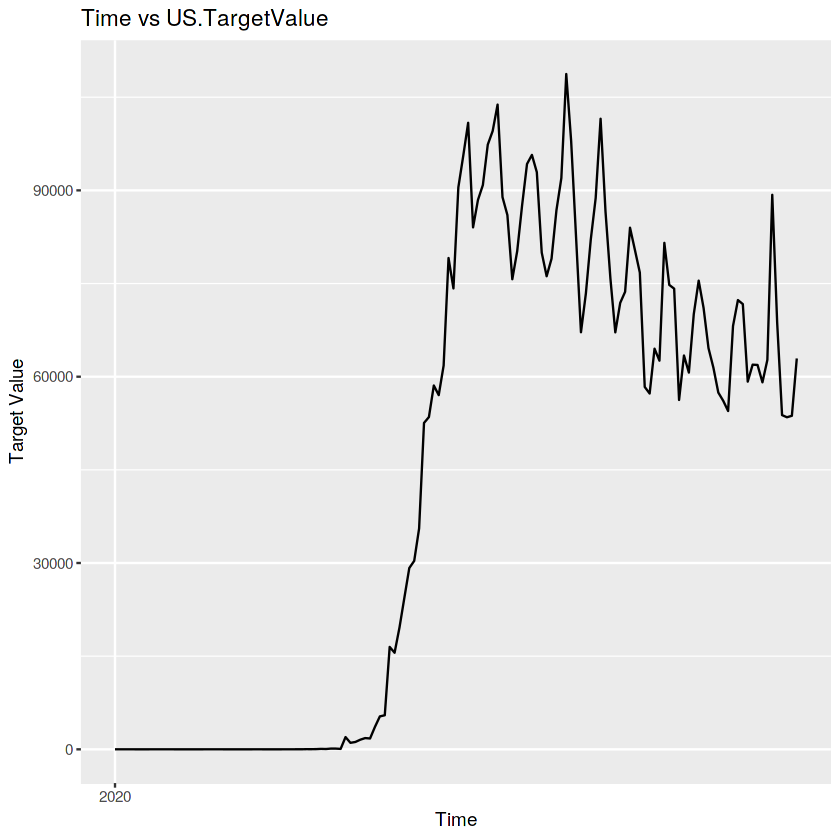

In [2]:
train<-read.csv("../input/covid19-global-forecasting-week-5/train.csv")
# Data Preparation
train1<-train[ which(train$Country_Region=='US' & train$Target=='ConfirmedCases'),]
train1$Date<-as.Date(train1$Date,"%Y-%m-%d")
UsConfirmed0<-aggregate(train1$TargetValue, by=list(Category=train1$Date), FUN=sum)
# Convert dataframe into time series data
UsConfirmed<-ts(UsConfirmed0$x,start=c(2020,01,23),frequency=365)
autoplot(UsConfirmed)+ylab("Target Value")+xlab("Time")+ggtitle("Time vs US.TargetValue")

---
## 1.1 Linear Trend and Quadratic Trend
* Linear Trend
* Quadratic trend with highest power (2,3,4)

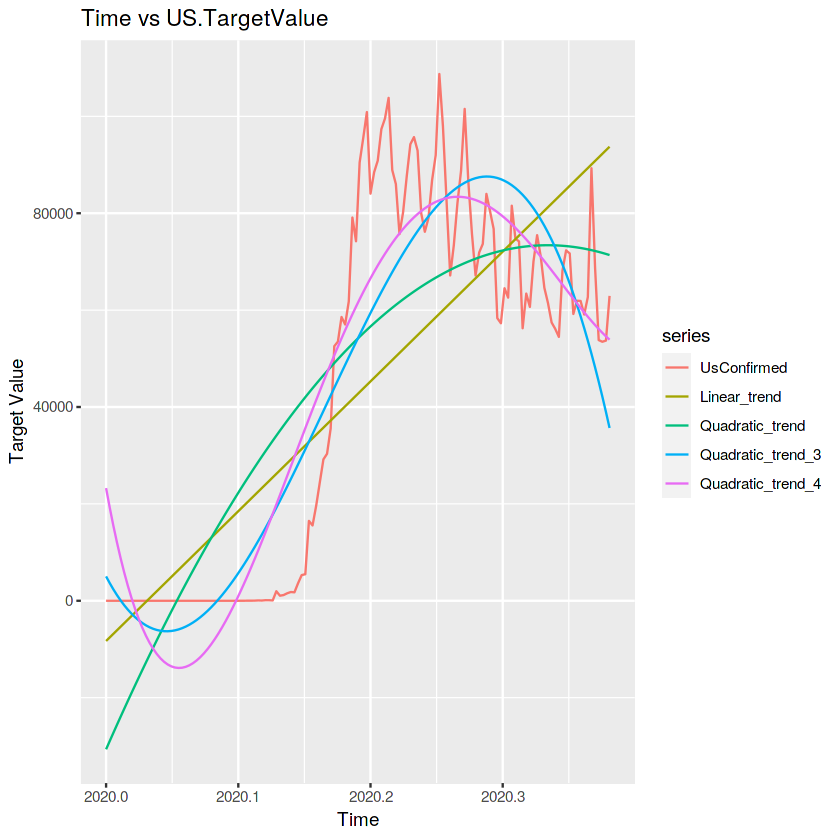

In [3]:
UsConfirmed_linear <- tslm(UsConfirmed~trend)
UsConfirmed_quad_2 <- tslm(UsConfirmed~trend+I(trend^2))
UsConfirmed_quad_3 <- tslm(UsConfirmed~trend+I(trend^2)+I(trend^3))
UsConfirmed_quad_4<- tslm(UsConfirmed~trend+I(trend^2)+I(trend^3)+I(trend^4))

UsConfirmed_with_fits<-cbind(UsConfirmed,Linear_trend=fitted(UsConfirmed_linear),Quadratic_trend=fitted(UsConfirmed_quad_2),
                            Quadratic_trend_3=fitted(UsConfirmed_quad_3),Quadratic_trend_4=fitted(UsConfirmed_quad_4))

autoplot(UsConfirmed_with_fits)+ylab("Target Value")+xlab("Time")+ggtitle("Time vs US.TargetValue")

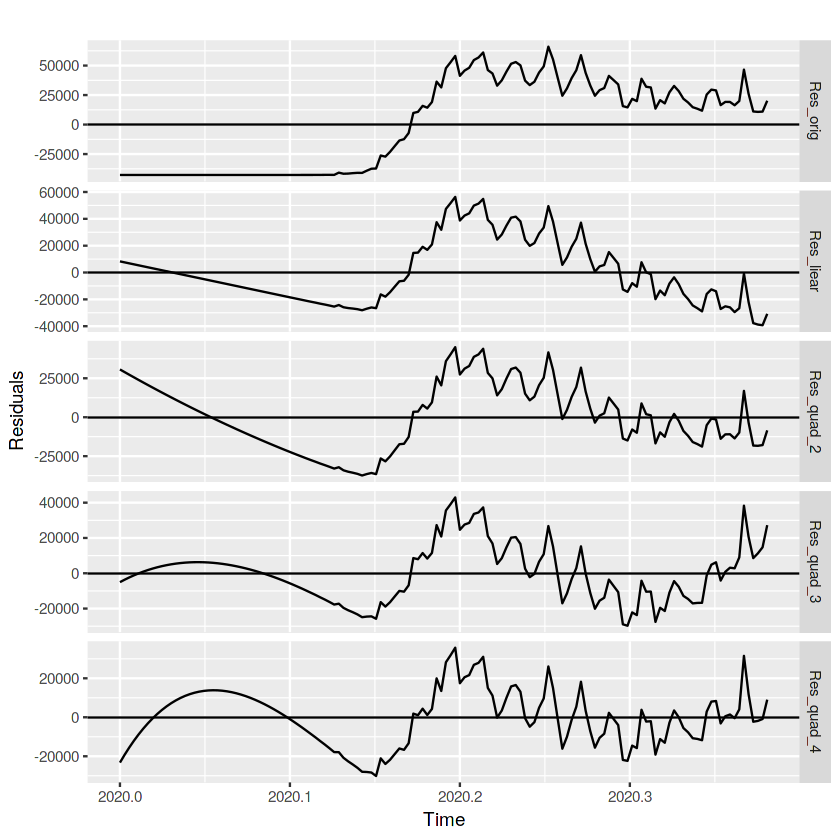

In [4]:
UsConfirmed_resids<-cbind(Res_orig=UsConfirmed-mean(UsConfirmed),
                         Res_liear=UsConfirmed-fitted(UsConfirmed_linear),
                         Res_quad_2=UsConfirmed-fitted(UsConfirmed_quad_2),
                         Res_quad_3=UsConfirmed-fitted(UsConfirmed_quad_3),
                         Res_quad_4=UsConfirmed-fitted(UsConfirmed_quad_4))


autoplot(UsConfirmed_resids,facet=TRUE)+ylab("Residuals")+xlab("Time")+geom_hline(yintercept=0)

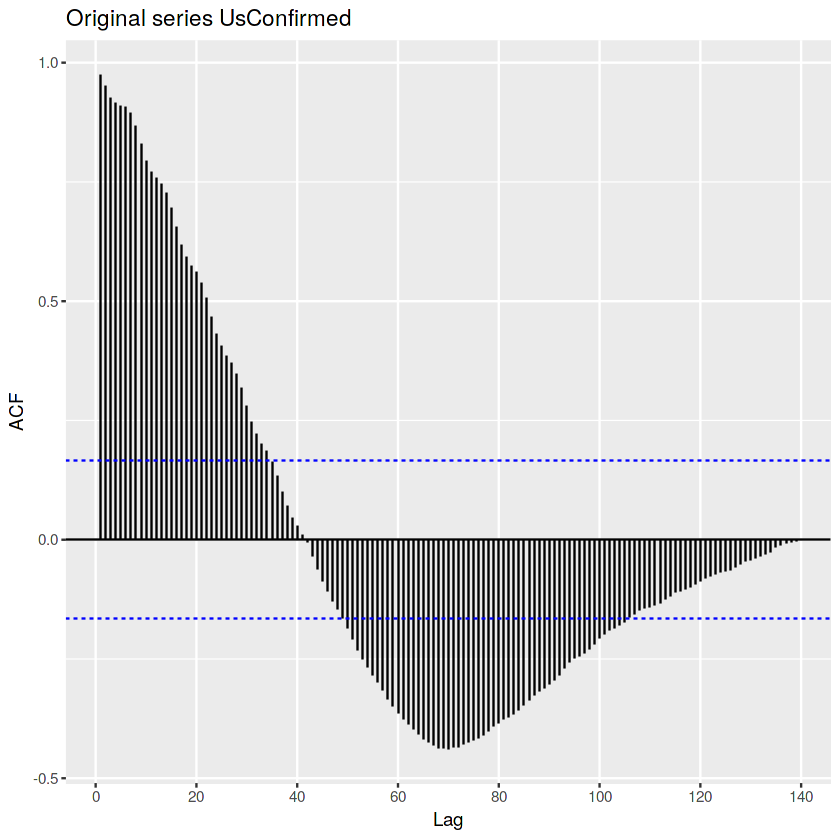

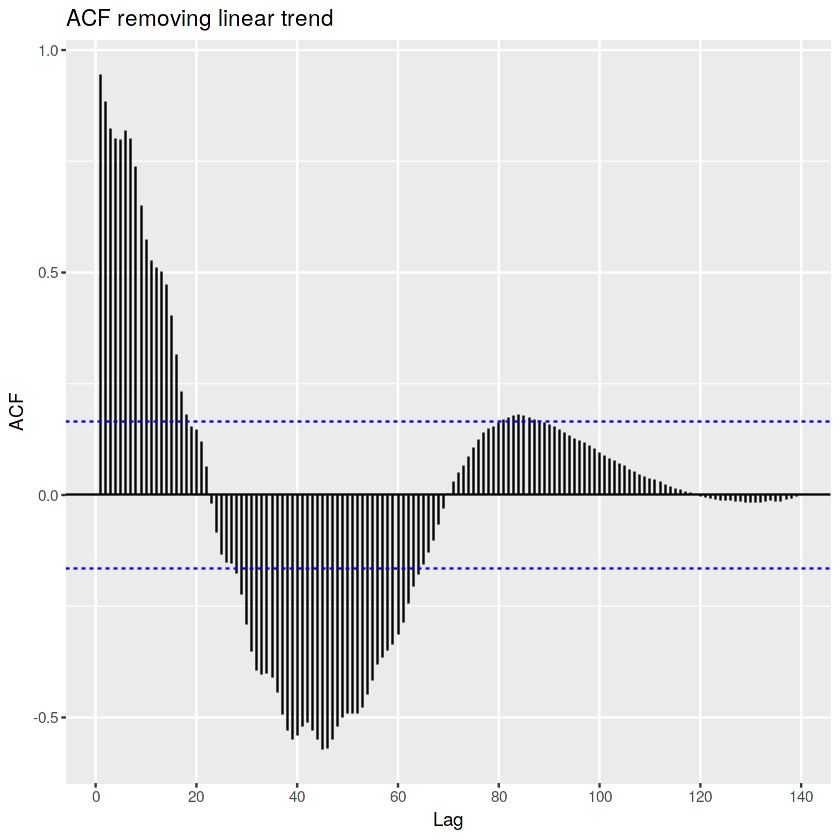

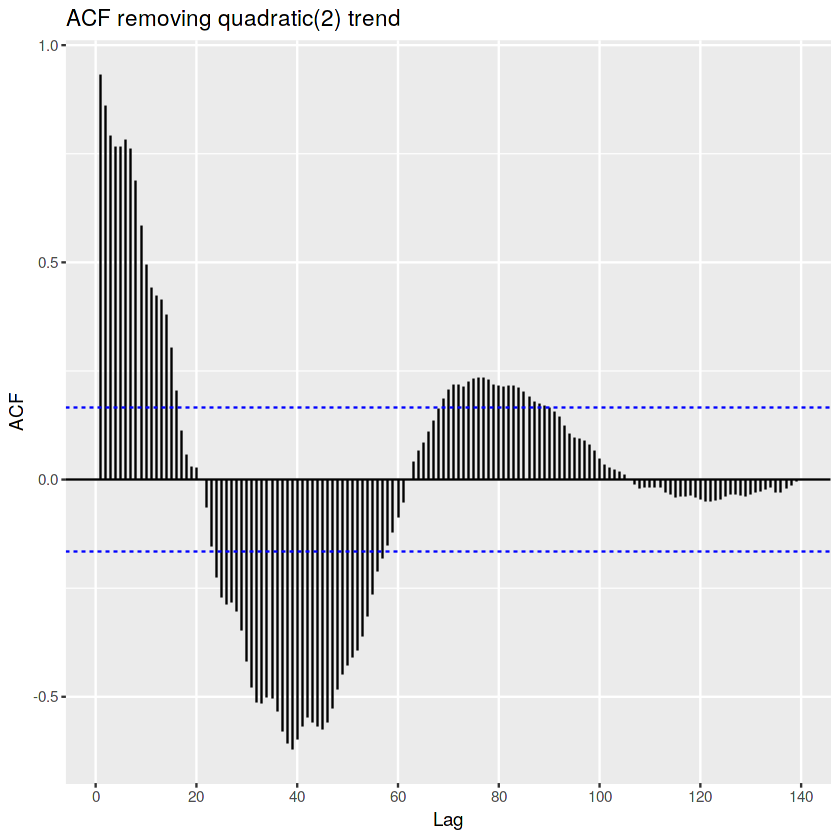

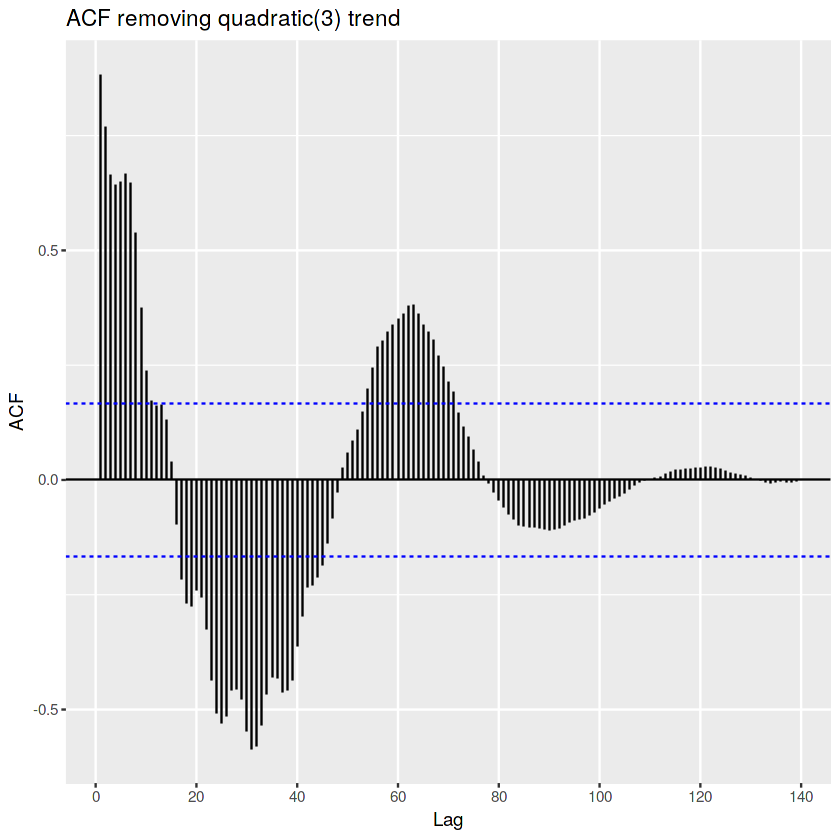

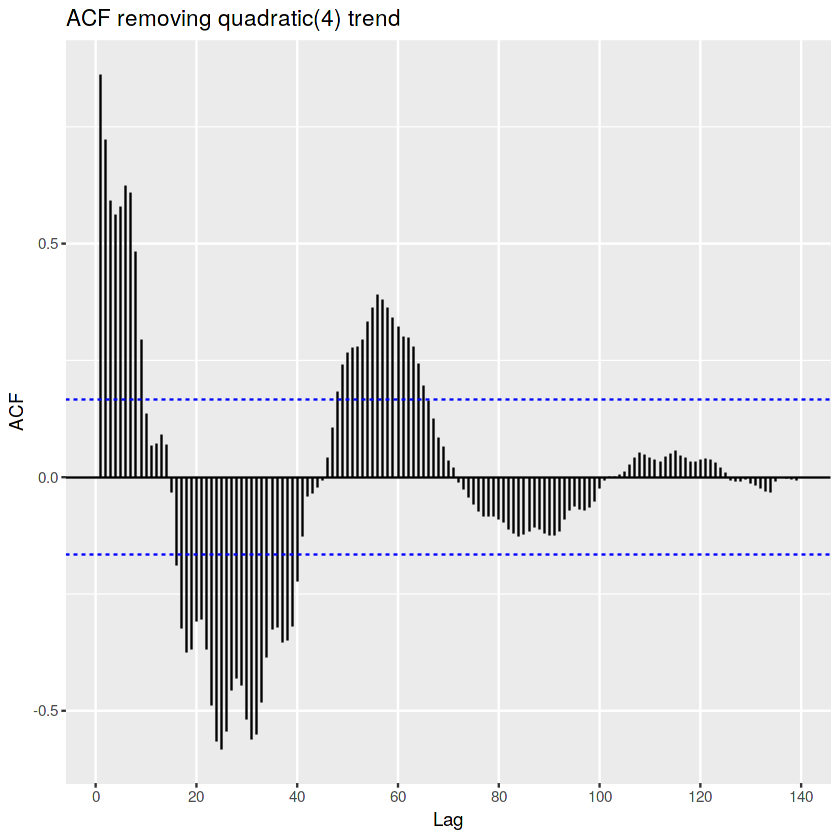

In [5]:
# ACF of Original Data
ggAcf(UsConfirmed)+ggtitle("Original series UsConfirmed")
# ACF removing Linear trend
ggAcf(UsConfirmed-fitted(UsConfirmed_linear))+ggtitle("ACF removing linear trend")
# ACF removing quadratic(2) trend
ggAcf(UsConfirmed-fitted(UsConfirmed_quad_2))+ggtitle("ACF removing quadratic(2) trend")
# ACF removing quadratic(3) trend
ggAcf(UsConfirmed-fitted(UsConfirmed_quad_3))+ggtitle("ACF removing quadratic(3) trend")
# ACF removing quadratic(4) trend
ggAcf(UsConfirmed-fitted(UsConfirmed_quad_4))+ggtitle("ACF removing quadratic(4) trend")

------
## 1.2 Moving Average and Differencing

### Computing the trend
* MA7, MA5 and MA3
* Differencing

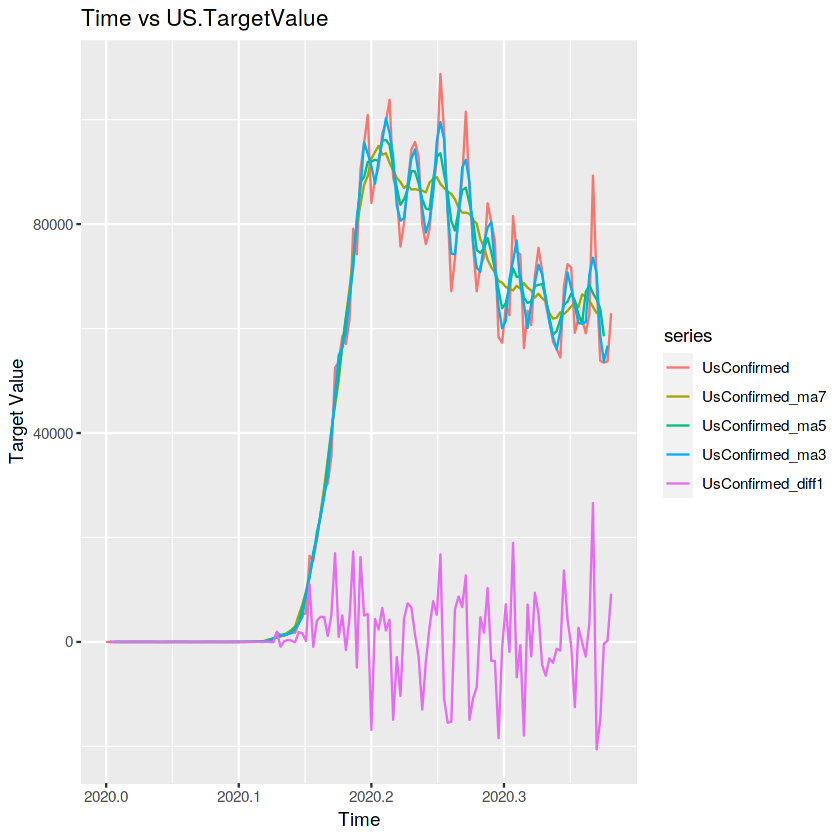

In [6]:

UsConfirmed_ma7<-ma(UsConfirmed,order=7)
UsConfirmed_ma5<-ma(UsConfirmed,order=5)
UsConfirmed_ma3<-ma(UsConfirmed,order=3)
UsConfirmed_diff1<-diff(UsConfirmed,1)

UsConfirmed_with_fits<-cbind(UsConfirmed,UsConfirmed_ma7=UsConfirmed_ma7,UsConfirmed_ma5=UsConfirmed_ma5
                            ,UsConfirmed_ma3=UsConfirmed_ma3, UsConfirmed_diff1=UsConfirmed_diff1)


autoplot(UsConfirmed_with_fits)+ylab("Target Value")+xlab("Time")+ggtitle("Time vs US.TargetValue")

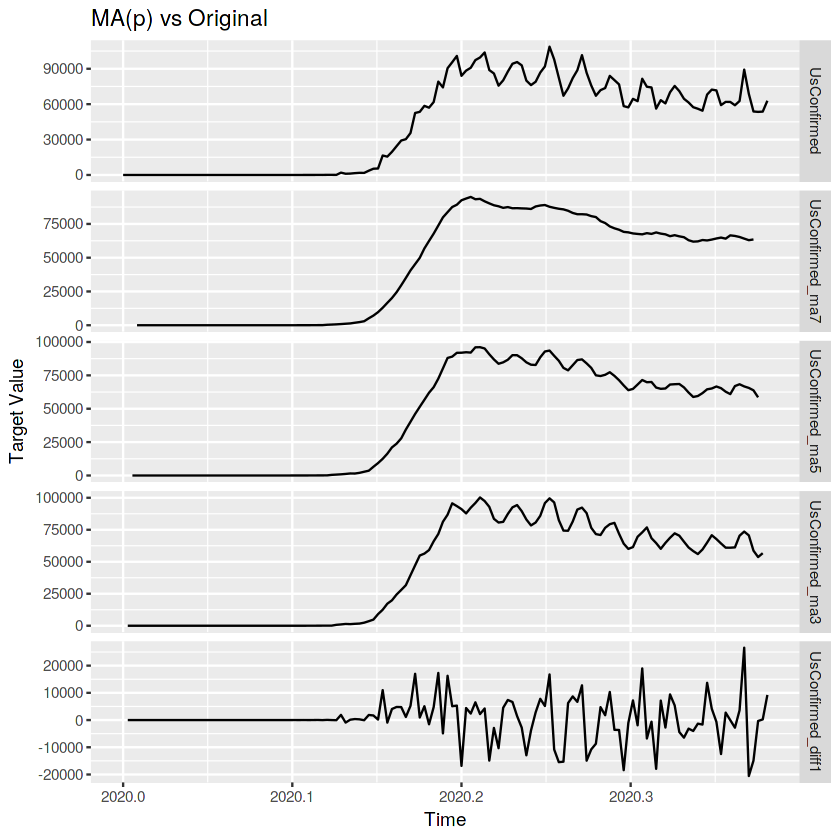

In [7]:
autoplot(UsConfirmed_with_fits[,c("UsConfirmed","UsConfirmed_ma7","UsConfirmed_ma5","UsConfirmed_ma3","UsConfirmed_diff1")], facet=TRUE)+ylab("Target Value")+xlab("Time")+ggtitle("MA(p) vs Original")

### Visualize the residual

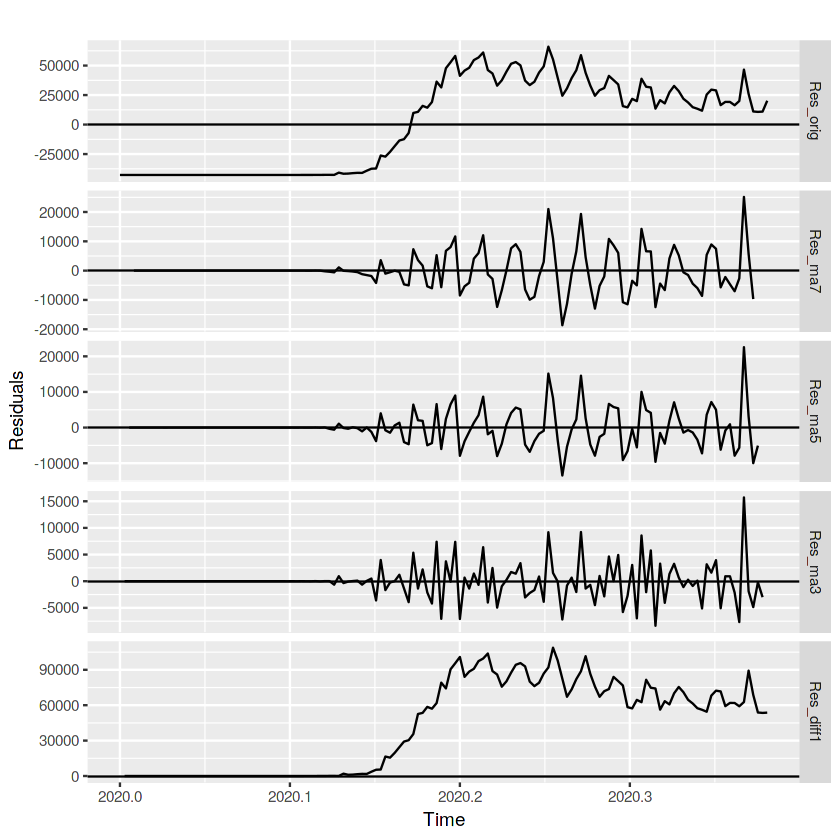

In [8]:
#dev.new(width=550, height=330)
UsConfirmed_resids<-cbind(Res_orig=UsConfirmed-mean(UsConfirmed),
                         Res_ma7 = UsConfirmed-UsConfirmed_ma7,
                         Res_ma5 = UsConfirmed-UsConfirmed_ma5,
                        Res_ma3 = UsConfirmed-UsConfirmed_ma3,
                         Res_diff1=UsConfirmed-UsConfirmed_diff1)


autoplot(UsConfirmed_resids,facet=TRUE)+ylab("Residuals")+xlab("Time")+geom_hline(yintercept=0)

### Autocorrelation

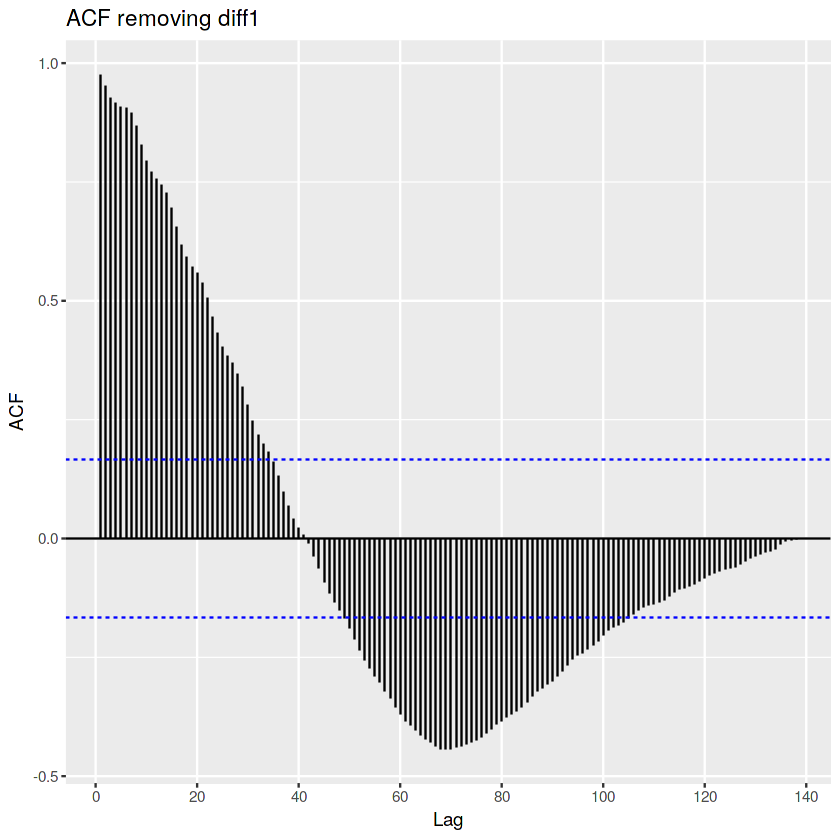

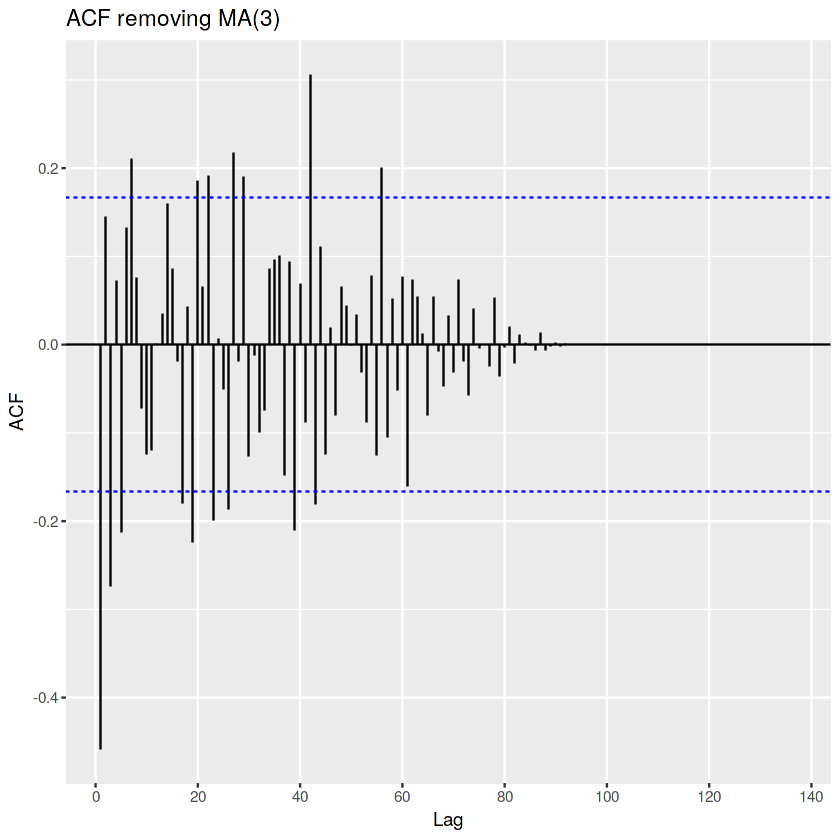

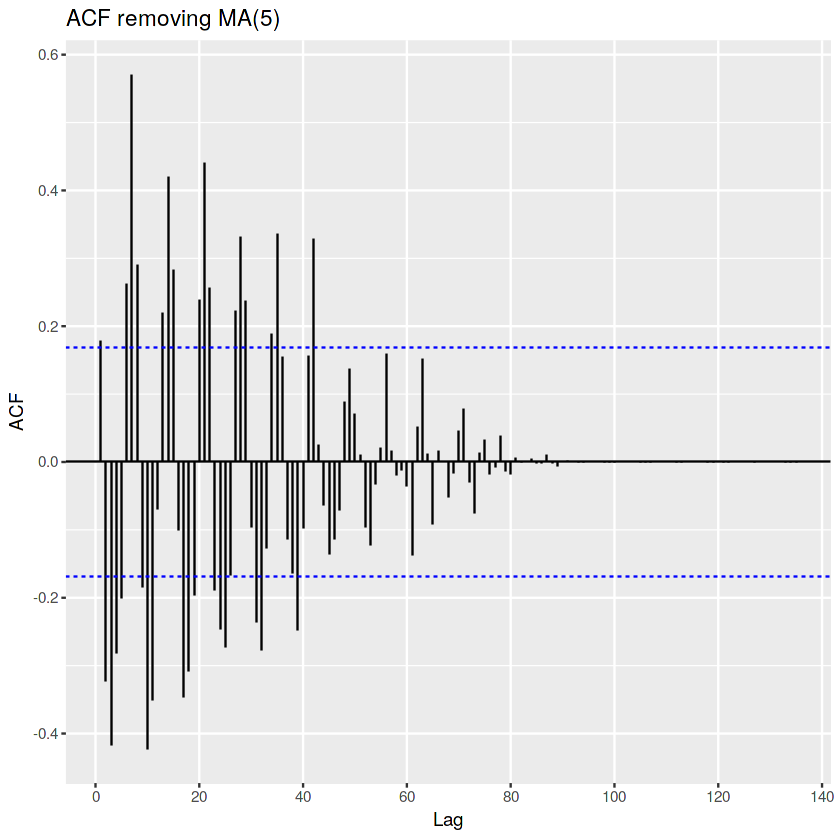

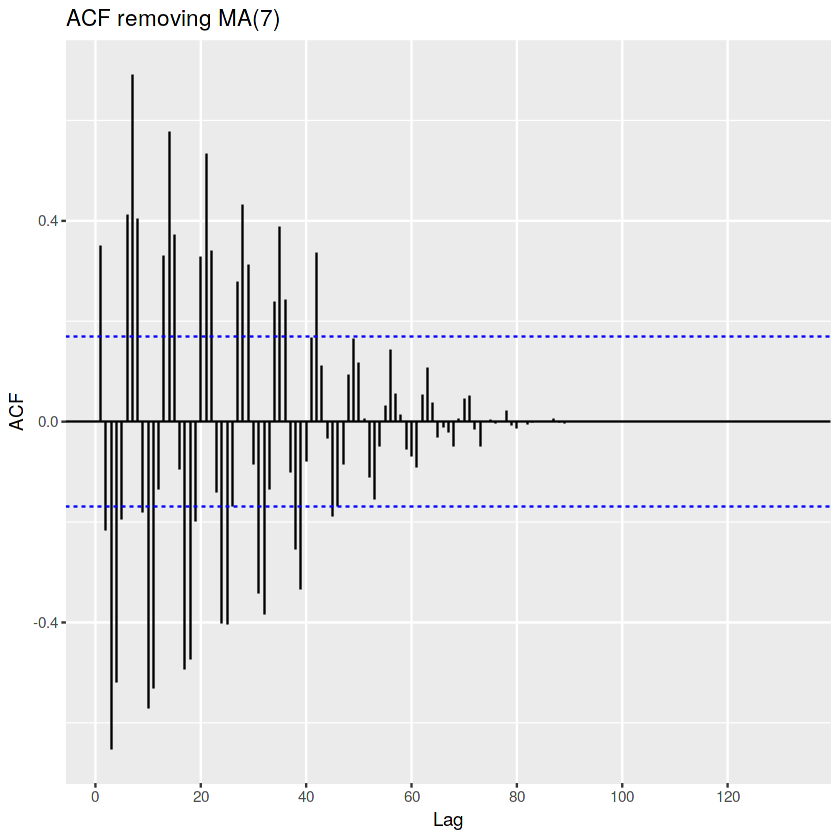

In [9]:

ggAcf(UsConfirmed-UsConfirmed_diff1)+ggtitle("ACF removing diff1")
ggAcf(UsConfirmed-UsConfirmed_ma3)+ggtitle("ACF removing MA(3)")
ggAcf(UsConfirmed-UsConfirmed_ma5)+ggtitle("ACF removing MA(5)")
ggAcf(UsConfirmed-UsConfirmed_ma7)+ggtitle("ACF removing MA(7)")

* Model MA(3) has a better estimation of trend



### Seasonality Estimation

* It seems no seasonality component

[1] 365

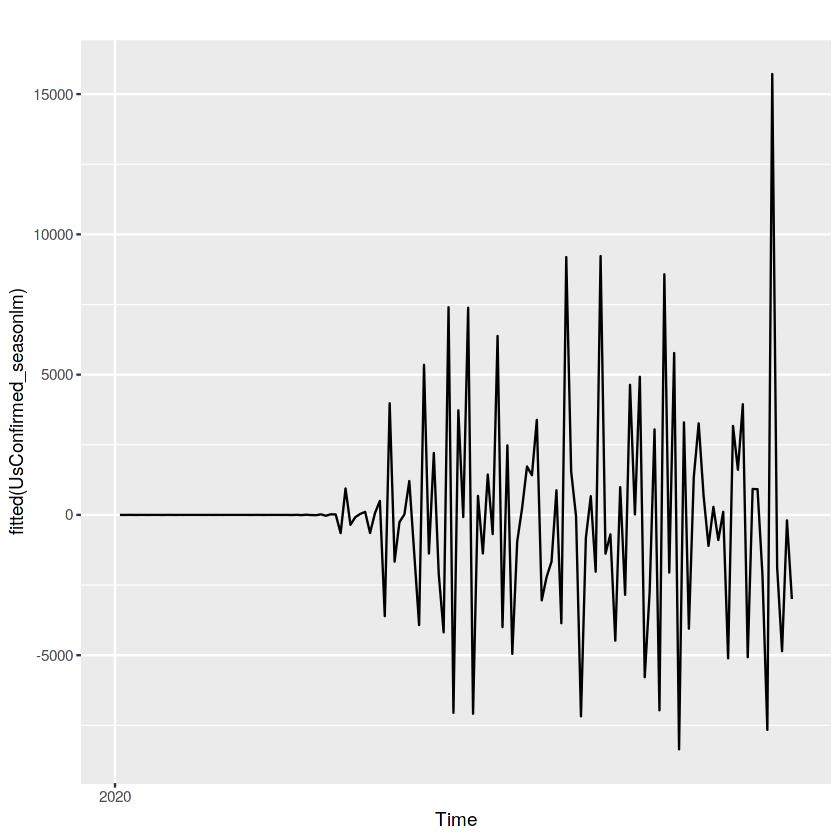

In [10]:
frequency(UsConfirmed_resids[,"Res_ma3"])
UsConfirmed_seasonlm<-tslm(Res_ma3~season,data=UsConfirmed_resids)
autoplot(fitted(UsConfirmed_seasonlm))

## Test
* The hypothesis testing result (p-value) can tell us whether the residual is iid noise
* It is accepted by most of the tests

Null hypothesis: Residuals are iid noise.
Test                        Distribution Statistic   p-value
Ljung-Box Q                Q ~ chisq(20)     90.81         0 *
McLeod-Li Q                Q ~ chisq(20)     25.37    0.1876
Turning points T   (T-90.7)/4.9 ~ N(0,1)        98    0.1361
Diff signs S       (S-68.5)/3.4 ~ N(0,1)        63    0.1061
Rank P         (P-4726.5)/271.6 ~ N(0,1)      4522    0.4515


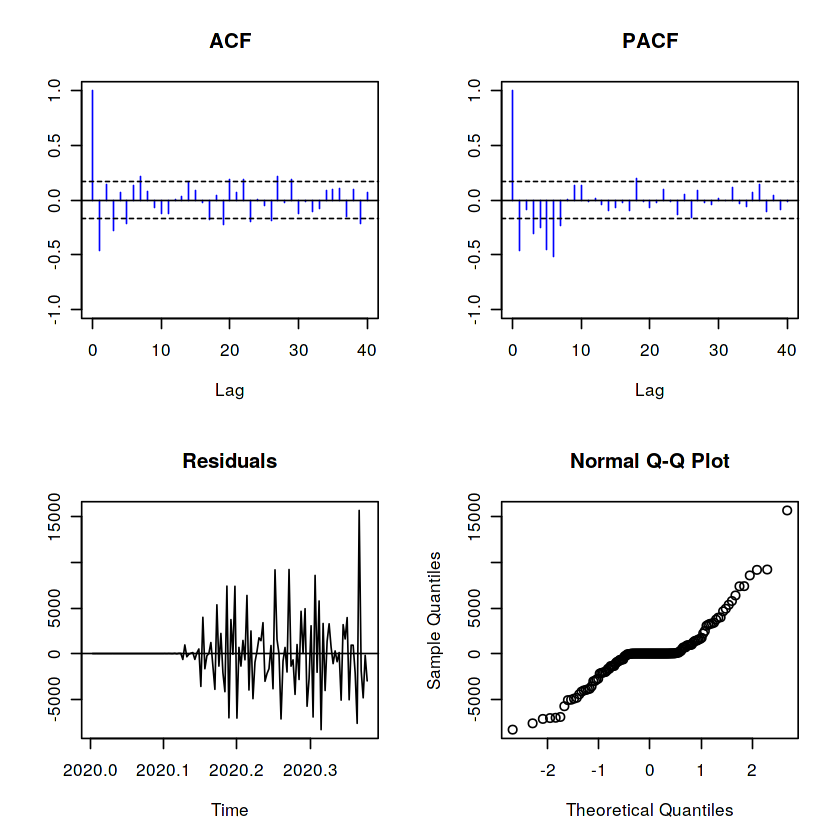

In [11]:

test(UsConfirmed_resids[,"Res_ma3"] %>% na.omit(.))

## 1.2 ARMA

### Estimation via Yule_Walker,Burg, and MLE

In [12]:
yw<-ar(UsConfirmed,method="yw",aic=FALSE,order.max=20)
burg<-ar(UsConfirmed,method="burg",aic=FALSE,order.max=20)
mle<-ar(UsConfirmed,method="mle",aic=FALSE,order.max=20)

ar_map<-map_df(c("yw","burg","mle"), 
              function(x){
                  myfit=ar(UsConfirmed,method=x,aic=FALSE , order.max=20)
                  tibble(method=x, coef_ind=1:20, coef=myfit[["ar"]],se=sqrt(diag(myfit[["asy.var.coef"]]))) })
ar_map %>% filter(method=="yw")%>% kable(.)



|method | coef_ind|       coef|        se|
|:------|--------:|----------:|---------:|
|yw     |        1|  0.8361503| 0.0908929|
|yw     |        2|  0.1218591| 0.1180669|
|yw     |        3| -0.1218730| 0.1185703|
|yw     |        4|  0.2149214| 0.1190259|
|yw     |        5| -0.0077448| 0.1204272|
|yw     |        6|  0.0488074| 0.1203442|
|yw     |        7|  0.1780302| 0.1203396|
|yw     |        8| -0.1125306| 0.1214051|
|yw     |        9| -0.1945138| 0.1216743|
|yw     |       10| -0.0874171| 0.1229639|
|yw     |       11|  0.0171281| 0.1229639|
|yw     |       12|  0.0698345| 0.1216743|
|yw     |       13|  0.0322970| 0.1214051|
|yw     |       14|  0.0501213| 0.1203396|
|yw     |       15|  0.0493915| 0.1203442|
|yw     |       16| -0.0791308| 0.1204272|
|yw     |       17| -0.0443914| 0.1190259|
|yw     |       18|  0.0259379| 0.1185703|
|yw     |       19| -0.1530795| 0.1180669|
|yw     |       20|  0.1299209| 0.0908929|

In [13]:
ar_map %>% filter(method=="burg")%>% kable(.)



|method | coef_ind|       coef|        se|
|:------|--------:|----------:|---------:|
|burg   |        1|  0.6622199| 0.0574036|
|burg   |        2|  0.2605874| 0.0745654|
|burg   |        3| -0.0274789| 0.0748833|
|burg   |        4|  0.2518432| 0.0751711|
|burg   |        5| -0.0861915| 0.0760561|
|burg   |        6|  0.2727425| 0.0760036|
|burg   |        7|  0.3006844| 0.0760008|
|burg   |        8| -0.3438449| 0.0766737|
|burg   |        9| -0.3431551| 0.0768437|
|burg   |       10| -0.2024732| 0.0776581|
|burg   |       11| -0.0483181| 0.0776581|
|burg   |       12|  0.2181013| 0.0768437|
|burg   |       13| -0.0236240| 0.0766737|
|burg   |       14| -0.0187119| 0.0760008|
|burg   |       15|  0.2110399| 0.0760036|
|burg   |       16| -0.0152544| 0.0760561|
|burg   |       17|  0.0457572| 0.0751711|
|burg   |       18|  0.0351229| 0.0748833|
|burg   |       19| -0.3519640| 0.0745654|
|burg   |       20|  0.1865570| 0.0574036|

In [14]:
ar_map %>% filter(method=="mle")%>% kable(.)



|method | coef_ind|       coef|        se|
|:------|--------:|----------:|---------:|
|mle    |        1|  0.6568305| 0.0570906|
|mle    |        2|  0.2682592| 0.0741588|
|mle    |        3| -0.0442809| 0.0744750|
|mle    |        4|  0.2683229| 0.0747612|
|mle    |        5| -0.0966634| 0.0756413|
|mle    |        6|  0.2217427| 0.0755892|
|mle    |        7|  0.3667161| 0.0755863|
|mle    |        8| -0.3448729| 0.0762556|
|mle    |        9| -0.3177255| 0.0764246|
|mle    |       10| -0.2181355| 0.0772346|
|mle    |       11| -0.0770290| 0.0772346|
|mle    |       12|  0.2658572| 0.0764246|
|mle    |       13| -0.0645137| 0.0762556|
|mle    |       14| -0.0188399| 0.0755863|
|mle    |       15|  0.2269787| 0.0755892|
|mle    |       16| -0.0610962| 0.0756413|
|mle    |       17|  0.0899312| 0.0747612|
|mle    |       18|  0.0358714| 0.0744750|
|mle    |       19| -0.3731524| 0.0741588|
|mle    |       20|  0.1990827| 0.0570906|

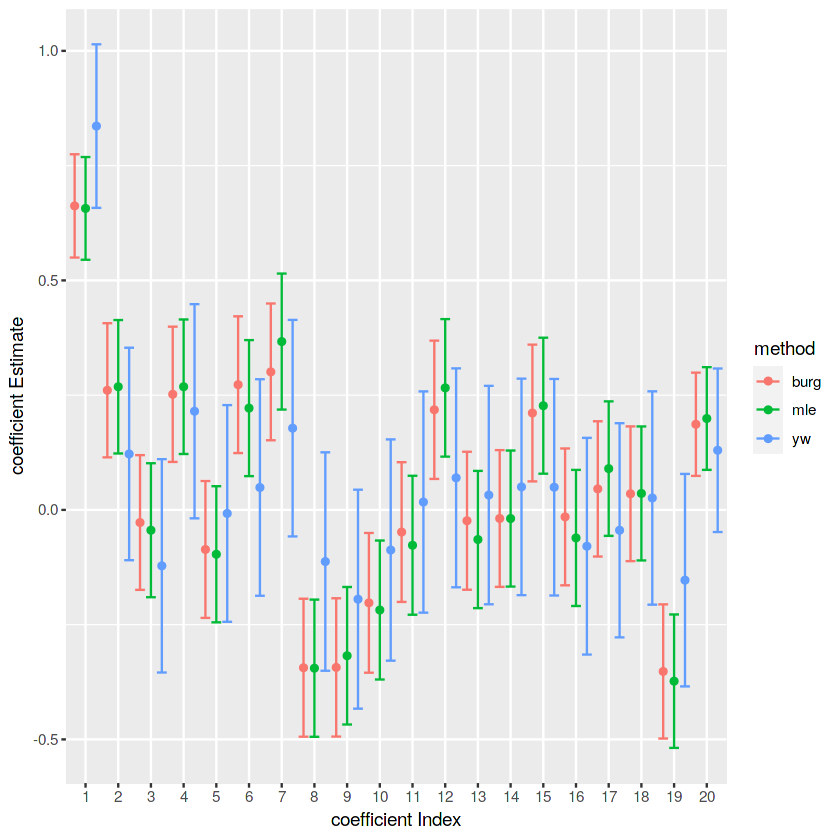

In [15]:
# plotting the estimation of each method
# Also their 95% confidence interval
ggplot(ar_map,aes(x=factor(coef_ind),y=coef,colour=method,ymin=coef-1.96*se, ymax=coef+1.96*se))+ 
geom_errorbar(position=position_dodge(width=1)) + 
geom_point(position=position_dodge(width=1))+
xlab("coefficient Index")+
ylab("coefficient Estimate")
    

* Consider ARMA(3,1)
* $\phi = ({\phi_1,\phi_2,\phi_3,...,\phi_{19},\phi_{20}})=(0.6,0.12,0,0.2,0,0,0.2,-0.2,-0.2,0,0,0,0,0,0,0,0,0,-0.2,0.17)$ and $\theta= 0$
* All the roots of AR polynomial and MA polynomial: $|z|>=1$
* This is a causal and invertible process

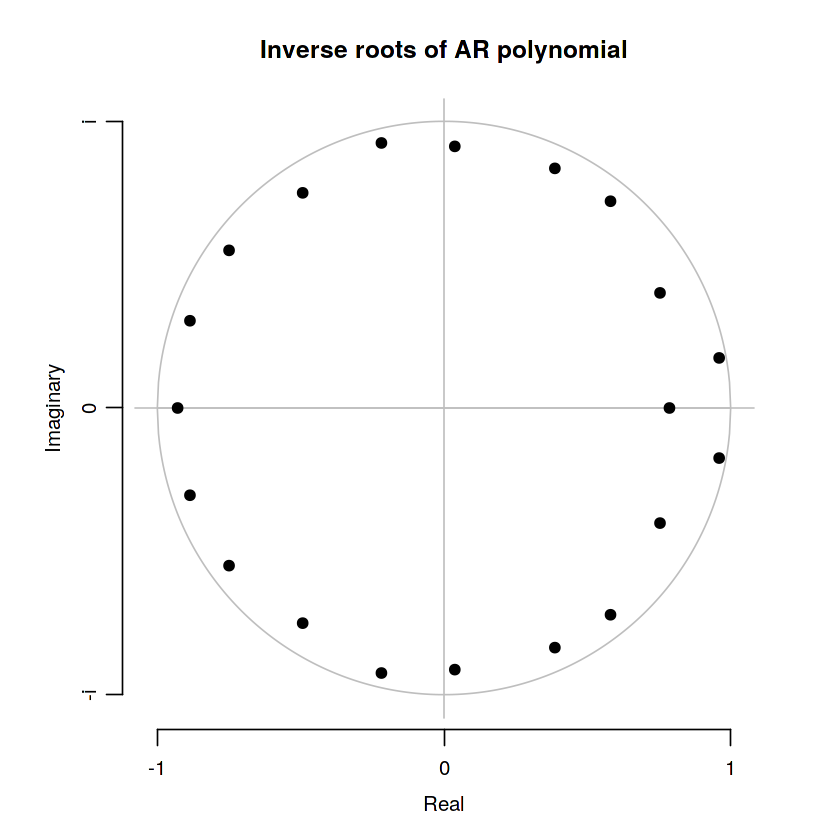

In [16]:
ar_coef=c(0.6,0.12,0,0.2,0,0,0.2,-0.2,-0.2,0,0,0,0,0,0,0,0,0,-0.2,0.17)
ma_coef=c(0)
ARMA_3_1_model=list(ar=ar_coef,ma=ma_coef)
ar_roots<-polyroot(c(1,-ARMA_3_1_model$ar))
#ma_roots<-polyroot(c(1,ARMA_3_1_model$ma))
forecast:::plot.armaroots(structure(list(roots=ar_roots),class="armaroots"), xlab="Real",ylab="Imaginary",main="Inverse roots of AR polynomial")
#forecast:::plot.armaroots(structure(list(roots=ma_roots),class="armaroots"), xlab="Real",ylab="Imaginary",main="Inverse roots of MA polynomial")

* ARMAacf can give the thoretical ACF and PACF of ARMA(20,0)
* Plotting UsConfirmed and ARMA(20,0)

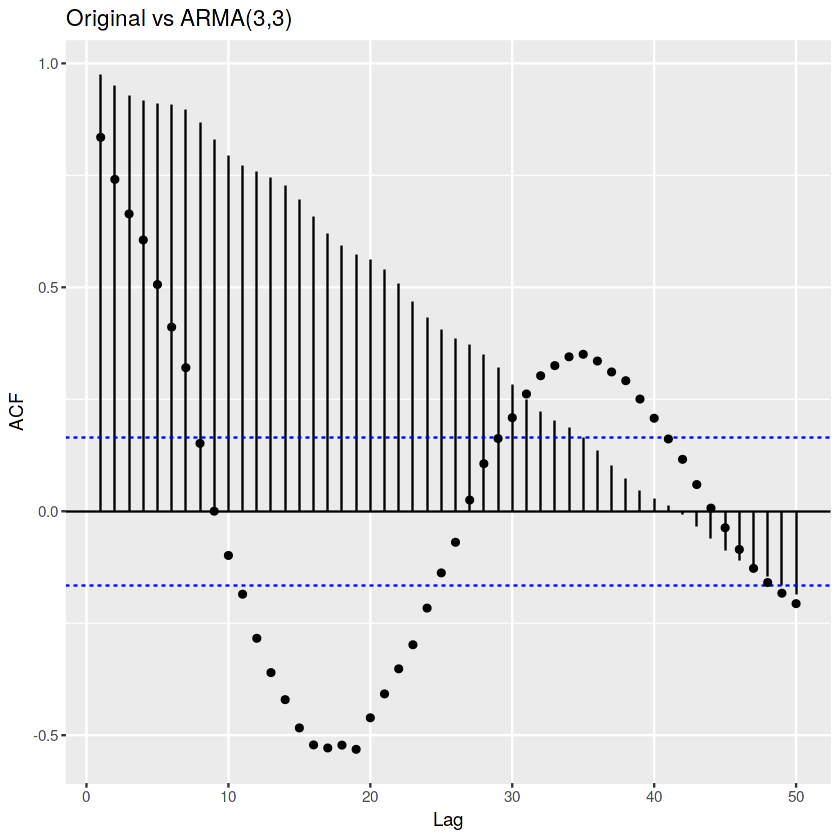

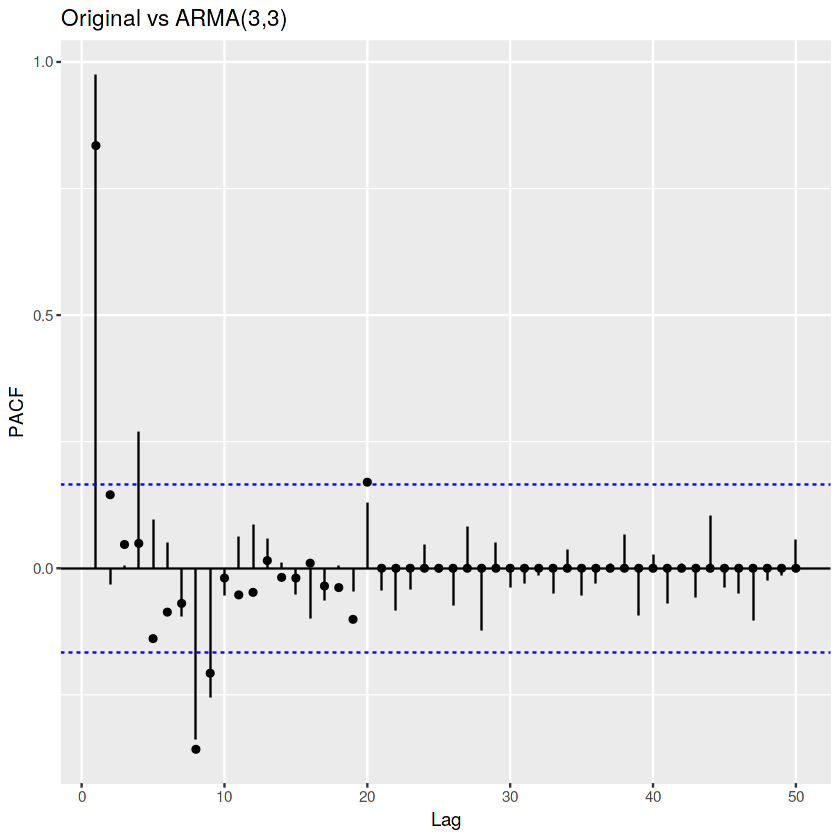

In [17]:

ggAcf(UsConfirmed,lag.max=50)+geom_point(aes(y=ARMAacf(ar=ar_coef,ma=ma_coef,lag.max=50)[-1]))+ggtitle("Original vs ARMA(3,3)")
ggPacf(UsConfirmed,lag.max=50)+geom_point(aes(y=ARMAacf(ar=ar_coef,ma=ma_coef,lag.max=50,pacf=TRUE)))+ggtitle("Original vs ARMA(3,3)")

## 1.4 ARIMA